In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [4]:
    train_dir = 'data/kaggle_histo/train/'
test_dir = "data/kaggle_histo/test/"

extracted_features_dir = "extracted_features/"
model_name = "kaggle_VGG16"

In [5]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [6]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/kaggle_histo/train/ 0
data/kaggle_histo/train/cancer 256400
data/kaggle_histo/train/normal 375900
******************************
data/kaggle_histo/test/ 0
data/kaggle_histo/test/cancer 6368
data/kaggle_histo/test/normal 9376


In [8]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 474225 images belonging to 2 classes.
Found 158075 images belonging to 2 classes.
Found 15744 images belonging to 2 classes.


In [9]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 474225
nb_validation_samples: 158075

predict_size_train: 14820
predict_size_validation: 4940
nb_test_samples: 15744
predict_size_test: 492

 num_classes: 2


In [10]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [11]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [12]:
input_tensor = Input(shape = input_shape)  
model = VGG16(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [13]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [14]:
# c1 = model.layers[4].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[7].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[12].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[17].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [15]:
# bottleneck_final_model.summary()

In [16]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [17]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [18]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [19]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 474225 samples, validate on 158075 samples
Epoch 1/1000
 - 44s - loss: 0.3754 - acc: 0.8343 - val_loss: 0.3343 - val_acc: 0.8548
Epoch 2/1000
 - 43s - loss: 0.3359 - acc: 0.8559 - val_loss: 0.3203 - val_acc: 0.8627
Epoch 3/1000
 - 42s - loss: 0.3255 - acc: 0.8631 - val_loss: 0.3181 - val_acc: 0.8655
Epoch 4/1000
 - 43s - loss: 0.3209 - acc: 0.8668 - val_loss: 0.3097 - val_acc: 0.8712
Epoch 5/1000
 - 43s - loss: 0.3180 - acc: 0.8695 - val_loss: 0.3072 - val_acc: 0.8735
Epoch 6/1000
 - 43s - loss: 0.3162 - acc: 0.8711 - val_loss: 0.3053 - val_acc: 0.8756
Epoch 7/1000
 - 43s - loss: 0.3151 - acc: 0.8728 - val_loss: 0.3023 - val_acc: 0.8765
Epoch 8/1000
 - 43s - loss: 0.3147 - acc: 0.8733 - val_loss: 0.3065 - val_acc: 0.8764
Epoch 9/1000
 - 43s - loss: 0.3138 - acc: 0.8744 - val_loss: 0.3025 - val_acc: 0.8781
Epoch 10/1000
 - 43s - loss: 0.3140 - acc: 0.8747 - val_loss: 0.3028 - val_acc: 0.8781
Epoch 11/1000
 - 42s - loss: 0.3136 - acc: 0.8752 - val_loss: 0.3029 - val_acc: 0.8782


Epoch 95/1000
 - 42s - loss: 0.3293 - acc: 0.8804 - val_loss: 0.3172 - val_acc: 0.8851
Epoch 96/1000
 - 43s - loss: 0.3301 - acc: 0.8801 - val_loss: 0.3154 - val_acc: 0.8840
Epoch 97/1000
 - 43s - loss: 0.3302 - acc: 0.8801 - val_loss: 0.3183 - val_acc: 0.8843
Epoch 98/1000
 - 42s - loss: 0.3291 - acc: 0.8803 - val_loss: 0.3171 - val_acc: 0.8839
Epoch 99/1000
 - 43s - loss: 0.3297 - acc: 0.8801 - val_loss: 0.3187 - val_acc: 0.8843
Epoch 100/1000
 - 43s - loss: 0.3309 - acc: 0.8798 - val_loss: 0.3159 - val_acc: 0.8844
Epoch 101/1000
 - 42s - loss: 0.3310 - acc: 0.8801 - val_loss: 0.3166 - val_acc: 0.8846
Epoch 102/1000
 - 43s - loss: 0.3303 - acc: 0.8804 - val_loss: 0.3158 - val_acc: 0.8847
Epoch 103/1000
 - 43s - loss: 0.3307 - acc: 0.8801 - val_loss: 0.3177 - val_acc: 0.8846
Epoch 104/1000
 - 42s - loss: 0.3305 - acc: 0.8804 - val_loss: 0.3176 - val_acc: 0.8842
Epoch 105/1000
 - 43s - loss: 0.3307 - acc: 0.8803 - val_loss: 0.3186 - val_acc: 0.8853
Epoch 106/1000
 - 43s - loss: 0.3306 

 - 43s - loss: 0.3361 - acc: 0.8805 - val_loss: 0.3203 - val_acc: 0.8846
Epoch 189/1000
 - 42s - loss: 0.3365 - acc: 0.8805 - val_loss: 0.3224 - val_acc: 0.8848
Epoch 190/1000
 - 43s - loss: 0.3367 - acc: 0.8805 - val_loss: 0.3191 - val_acc: 0.8846
Epoch 191/1000
 - 42s - loss: 0.3346 - acc: 0.8802 - val_loss: 0.3221 - val_acc: 0.8842
Epoch 192/1000
 - 42s - loss: 0.3370 - acc: 0.8807 - val_loss: 0.3216 - val_acc: 0.8849
Epoch 193/1000
 - 43s - loss: 0.3365 - acc: 0.8801 - val_loss: 0.3222 - val_acc: 0.8845
Epoch 194/1000
 - 43s - loss: 0.3359 - acc: 0.8804 - val_loss: 0.3227 - val_acc: 0.8849
Epoch 195/1000
 - 43s - loss: 0.3363 - acc: 0.8804 - val_loss: 0.3226 - val_acc: 0.8849
Epoch 196/1000
 - 42s - loss: 0.3356 - acc: 0.8800 - val_loss: 0.3213 - val_acc: 0.8841
Epoch 197/1000
 - 43s - loss: 0.3363 - acc: 0.8802 - val_loss: 0.3226 - val_acc: 0.8844
Epoch 198/1000
 - 43s - loss: 0.3366 - acc: 0.8804 - val_loss: 0.3220 - val_acc: 0.8843
Epoch 199/1000
 - 43s - loss: 0.3360 - acc: 0.8

Epoch 282/1000
 - 43s - loss: 0.3394 - acc: 0.8797 - val_loss: 0.3262 - val_acc: 0.8842
Epoch 283/1000
 - 43s - loss: 0.3393 - acc: 0.8799 - val_loss: 0.3248 - val_acc: 0.8844
Epoch 284/1000
 - 43s - loss: 0.3401 - acc: 0.8800 - val_loss: 0.3254 - val_acc: 0.8840
Epoch 285/1000
 - 43s - loss: 0.3397 - acc: 0.8802 - val_loss: 0.3245 - val_acc: 0.8842
Epoch 286/1000
 - 43s - loss: 0.3408 - acc: 0.8805 - val_loss: 0.3252 - val_acc: 0.8840
Epoch 287/1000
 - 43s - loss: 0.3406 - acc: 0.8803 - val_loss: 0.3266 - val_acc: 0.8834
Epoch 288/1000
 - 43s - loss: 0.3398 - acc: 0.8802 - val_loss: 0.3263 - val_acc: 0.8840
Epoch 289/1000
 - 43s - loss: 0.3400 - acc: 0.8799 - val_loss: 0.3262 - val_acc: 0.8841
Epoch 290/1000
 - 43s - loss: 0.3392 - acc: 0.8805 - val_loss: 0.3291 - val_acc: 0.8838
Epoch 291/1000
 - 42s - loss: 0.3398 - acc: 0.8800 - val_loss: 0.3265 - val_acc: 0.8832
Epoch 292/1000
 - 43s - loss: 0.3390 - acc: 0.8810 - val_loss: 0.3281 - val_acc: 0.8836
Epoch 293/1000
 - 43s - loss: 0.

 - 43s - loss: 0.3432 - acc: 0.8802 - val_loss: 0.3330 - val_acc: 0.8836
Epoch 376/1000
 - 42s - loss: 0.3431 - acc: 0.8798 - val_loss: 0.3308 - val_acc: 0.8844
Epoch 377/1000
 - 43s - loss: 0.3443 - acc: 0.8795 - val_loss: 0.3319 - val_acc: 0.8836
Epoch 378/1000
 - 43s - loss: 0.3447 - acc: 0.8800 - val_loss: 0.3312 - val_acc: 0.8838
Epoch 379/1000
 - 43s - loss: 0.3441 - acc: 0.8802 - val_loss: 0.3307 - val_acc: 0.8845
Epoch 380/1000
 - 43s - loss: 0.3435 - acc: 0.8802 - val_loss: 0.3294 - val_acc: 0.8843
Epoch 381/1000
 - 43s - loss: 0.3445 - acc: 0.8797 - val_loss: 0.3300 - val_acc: 0.8840
Epoch 382/1000
 - 43s - loss: 0.3440 - acc: 0.8801 - val_loss: 0.3286 - val_acc: 0.8842
Epoch 383/1000
 - 43s - loss: 0.3434 - acc: 0.8801 - val_loss: 0.3340 - val_acc: 0.8836
Epoch 384/1000
 - 43s - loss: 0.3438 - acc: 0.8801 - val_loss: 0.3323 - val_acc: 0.8823
Epoch 385/1000
 - 43s - loss: 0.3443 - acc: 0.8800 - val_loss: 0.3300 - val_acc: 0.8842
Epoch 386/1000
 - 43s - loss: 0.3441 - acc: 0.8

Epoch 469/1000
 - 43s - loss: 0.3487 - acc: 0.8799 - val_loss: 0.3352 - val_acc: 0.8836
Epoch 470/1000
 - 43s - loss: 0.3479 - acc: 0.8800 - val_loss: 0.3353 - val_acc: 0.8841
Epoch 471/1000
 - 43s - loss: 0.3467 - acc: 0.8801 - val_loss: 0.3344 - val_acc: 0.8841
Epoch 472/1000
 - 43s - loss: 0.3472 - acc: 0.8799 - val_loss: 0.3342 - val_acc: 0.8837
Epoch 473/1000
 - 43s - loss: 0.3472 - acc: 0.8797 - val_loss: 0.3344 - val_acc: 0.8841
Epoch 474/1000
 - 43s - loss: 0.3478 - acc: 0.8796 - val_loss: 0.3337 - val_acc: 0.8842
Epoch 475/1000
 - 43s - loss: 0.3475 - acc: 0.8800 - val_loss: 0.3348 - val_acc: 0.8838
Epoch 476/1000
 - 43s - loss: 0.3478 - acc: 0.8799 - val_loss: 0.3360 - val_acc: 0.8836
Epoch 477/1000
 - 43s - loss: 0.3482 - acc: 0.8798 - val_loss: 0.3338 - val_acc: 0.8836
Epoch 478/1000
 - 43s - loss: 0.3473 - acc: 0.8801 - val_loss: 0.3342 - val_acc: 0.8836
Epoch 479/1000
 - 43s - loss: 0.3474 - acc: 0.8801 - val_loss: 0.3363 - val_acc: 0.8842
Epoch 480/1000
 - 43s - loss: 0.

 - 43s - loss: 0.3511 - acc: 0.8796 - val_loss: 0.3351 - val_acc: 0.8832
Epoch 563/1000
 - 44s - loss: 0.3496 - acc: 0.8798 - val_loss: 0.3391 - val_acc: 0.8838
Epoch 564/1000
 - 44s - loss: 0.3514 - acc: 0.8795 - val_loss: 0.3383 - val_acc: 0.8841
Epoch 565/1000
 - 43s - loss: 0.3495 - acc: 0.8800 - val_loss: 0.3399 - val_acc: 0.8829
Epoch 566/1000
 - 44s - loss: 0.3505 - acc: 0.8798 - val_loss: 0.3376 - val_acc: 0.8841
Epoch 567/1000
 - 43s - loss: 0.3502 - acc: 0.8799 - val_loss: 0.3372 - val_acc: 0.8839
Epoch 568/1000
 - 42s - loss: 0.3498 - acc: 0.8800 - val_loss: 0.3415 - val_acc: 0.8832
Epoch 569/1000
 - 44s - loss: 0.3507 - acc: 0.8796 - val_loss: 0.3380 - val_acc: 0.8833
Epoch 570/1000
 - 42s - loss: 0.3508 - acc: 0.8797 - val_loss: 0.3379 - val_acc: 0.8841
Epoch 571/1000
 - 44s - loss: 0.3508 - acc: 0.8798 - val_loss: 0.3393 - val_acc: 0.8842
Epoch 572/1000
 - 43s - loss: 0.3518 - acc: 0.8798 - val_loss: 0.3383 - val_acc: 0.8834
Epoch 573/1000
 - 43s - loss: 0.3506 - acc: 0.8

Epoch 656/1000
 - 44s - loss: 0.3542 - acc: 0.8799 - val_loss: 0.3422 - val_acc: 0.8840
Epoch 657/1000
 - 44s - loss: 0.3546 - acc: 0.8799 - val_loss: 0.3417 - val_acc: 0.8839
Epoch 658/1000
 - 44s - loss: 0.3552 - acc: 0.8796 - val_loss: 0.3415 - val_acc: 0.8833
Epoch 659/1000
 - 44s - loss: 0.3542 - acc: 0.8796 - val_loss: 0.3404 - val_acc: 0.8833
Epoch 660/1000
 - 44s - loss: 0.3542 - acc: 0.8800 - val_loss: 0.3408 - val_acc: 0.8839
Epoch 661/1000
 - 43s - loss: 0.3551 - acc: 0.8797 - val_loss: 0.3415 - val_acc: 0.8839
Epoch 662/1000
 - 43s - loss: 0.3552 - acc: 0.8794 - val_loss: 0.3425 - val_acc: 0.8838
Epoch 663/1000
 - 43s - loss: 0.3550 - acc: 0.8797 - val_loss: 0.3423 - val_acc: 0.8837
Epoch 664/1000
 - 43s - loss: 0.3546 - acc: 0.8795 - val_loss: 0.3413 - val_acc: 0.8837
Epoch 665/1000
 - 43s - loss: 0.3522 - acc: 0.8801 - val_loss: 0.3389 - val_acc: 0.8839
Epoch 666/1000
 - 43s - loss: 0.3538 - acc: 0.8795 - val_loss: 0.3434 - val_acc: 0.8835
Epoch 667/1000
 - 43s - loss: 0.

 - 43s - loss: 0.3568 - acc: 0.8797 - val_loss: 0.3453 - val_acc: 0.8834
Epoch 750/1000
 - 43s - loss: 0.3563 - acc: 0.8799 - val_loss: 0.3420 - val_acc: 0.8834
Epoch 751/1000
 - 43s - loss: 0.3560 - acc: 0.8796 - val_loss: 0.3436 - val_acc: 0.8832
Epoch 752/1000
 - 43s - loss: 0.3561 - acc: 0.8795 - val_loss: 0.3456 - val_acc: 0.8831
Epoch 753/1000
 - 42s - loss: 0.3552 - acc: 0.8794 - val_loss: 0.3447 - val_acc: 0.8840
Epoch 754/1000
 - 43s - loss: 0.3570 - acc: 0.8797 - val_loss: 0.3465 - val_acc: 0.8839
Epoch 755/1000
 - 43s - loss: 0.3565 - acc: 0.8798 - val_loss: 0.3429 - val_acc: 0.8836
Epoch 756/1000
 - 43s - loss: 0.3569 - acc: 0.8796 - val_loss: 0.3445 - val_acc: 0.8838
Epoch 757/1000
 - 43s - loss: 0.3573 - acc: 0.8803 - val_loss: 0.3451 - val_acc: 0.8838
Epoch 758/1000
 - 43s - loss: 0.3568 - acc: 0.8799 - val_loss: 0.3442 - val_acc: 0.8842
Epoch 759/1000
 - 43s - loss: 0.3571 - acc: 0.8795 - val_loss: 0.3468 - val_acc: 0.8833
Epoch 760/1000
 - 43s - loss: 0.3571 - acc: 0.8

Epoch 843/1000
 - 43s - loss: 0.3600 - acc: 0.8798 - val_loss: 0.3482 - val_acc: 0.8839
Epoch 844/1000
 - 43s - loss: 0.3601 - acc: 0.8796 - val_loss: 0.3479 - val_acc: 0.8834
Epoch 845/1000
 - 43s - loss: 0.3600 - acc: 0.8795 - val_loss: 0.3507 - val_acc: 0.8833
Epoch 846/1000
 - 43s - loss: 0.3601 - acc: 0.8793 - val_loss: 0.3476 - val_acc: 0.8838
Epoch 847/1000
 - 43s - loss: 0.3603 - acc: 0.8796 - val_loss: 0.3497 - val_acc: 0.8833
Epoch 848/1000
 - 43s - loss: 0.3616 - acc: 0.8795 - val_loss: 0.3469 - val_acc: 0.8834
Epoch 849/1000
 - 43s - loss: 0.3602 - acc: 0.8795 - val_loss: 0.3503 - val_acc: 0.8827
Epoch 850/1000
 - 43s - loss: 0.3600 - acc: 0.8796 - val_loss: 0.3484 - val_acc: 0.8835
Epoch 851/1000
 - 43s - loss: 0.3610 - acc: 0.8789 - val_loss: 0.3467 - val_acc: 0.8837
Epoch 852/1000
 - 43s - loss: 0.3617 - acc: 0.8793 - val_loss: 0.3478 - val_acc: 0.8827
Epoch 853/1000
 - 43s - loss: 0.3603 - acc: 0.8794 - val_loss: 0.3494 - val_acc: 0.8835
Epoch 854/1000
 - 43s - loss: 0.

 - 43s - loss: 0.3623 - acc: 0.8798 - val_loss: 0.3509 - val_acc: 0.8837
Epoch 937/1000
 - 43s - loss: 0.3636 - acc: 0.8795 - val_loss: 0.3521 - val_acc: 0.8826
Epoch 938/1000
 - 42s - loss: 0.3633 - acc: 0.8792 - val_loss: 0.3496 - val_acc: 0.8834
Epoch 939/1000
 - 42s - loss: 0.3626 - acc: 0.8793 - val_loss: 0.3496 - val_acc: 0.8834
Epoch 940/1000
 - 43s - loss: 0.3633 - acc: 0.8797 - val_loss: 0.3511 - val_acc: 0.8836
Epoch 941/1000
 - 43s - loss: 0.3629 - acc: 0.8793 - val_loss: 0.3506 - val_acc: 0.8835
Epoch 942/1000
 - 43s - loss: 0.3626 - acc: 0.8792 - val_loss: 0.3497 - val_acc: 0.8836
Epoch 943/1000
 - 43s - loss: 0.3634 - acc: 0.8794 - val_loss: 0.3521 - val_acc: 0.8833
Epoch 944/1000
 - 43s - loss: 0.3652 - acc: 0.8793 - val_loss: 0.3516 - val_acc: 0.8826
Epoch 945/1000
 - 43s - loss: 0.3625 - acc: 0.8791 - val_loss: 0.3510 - val_acc: 0.8832
Epoch 946/1000
 - 42s - loss: 0.3623 - acc: 0.8792 - val_loss: 0.3524 - val_acc: 0.8829
Epoch 947/1000
 - 42s - loss: 0.3650 - acc: 0.8

In [20]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8838922764227642


Confusion Matrix
[[5325 1043]
 [ 785 8591]]


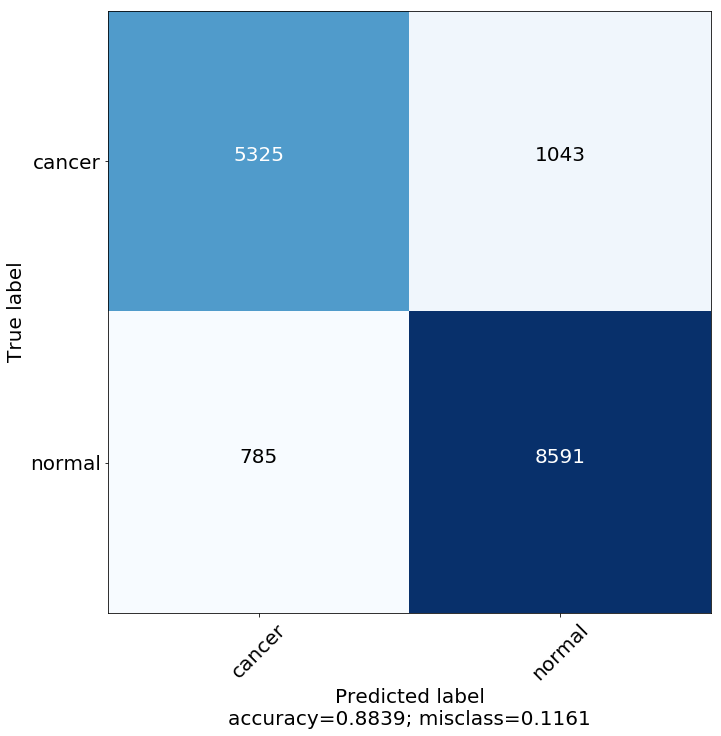

In [21]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[5325 1043]
 [ 785 8591]]
             precision    recall  f1-score   support

     cancer       0.87      0.84      0.85      6368
     normal       0.89      0.92      0.90      9376

avg / total       0.88      0.88      0.88     15744



In [23]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  87.15220949263502
Specificity :  89.17375960141166


In [24]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8816298454702335


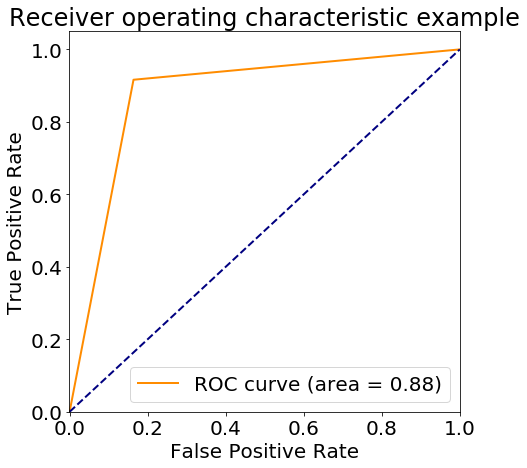

In [25]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [26]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

15744/15744 [==============================] - 0s 15us/step


In [27]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

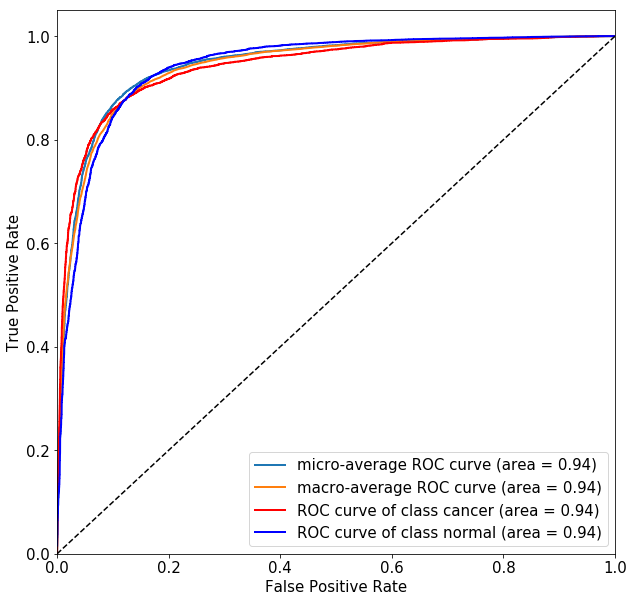

In [29]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [30]:
tn, fp, fn, tp = cm.ravel()

In [31]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8838922764227642
Precision: 0.8917375960141166
Recall: 0.9162755972696246
tp: 8591
fp: 1043
tn: 5325
fn: 785


In [32]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.9038400841662282


In [33]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9038400841662282


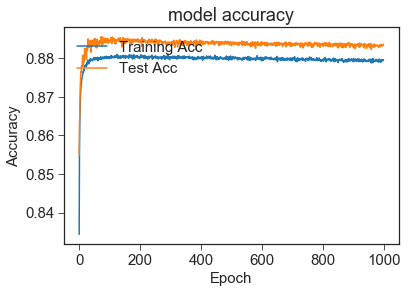

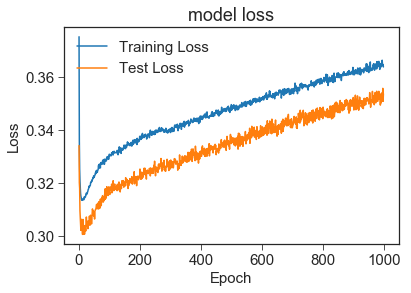

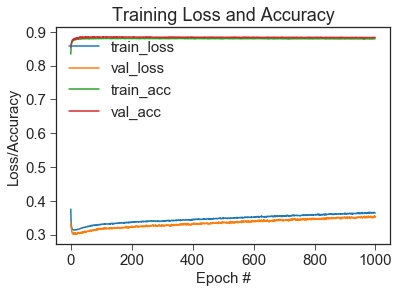

In [34]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")